In [2]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from copy import deepcopy

from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv(r"C:\Users\hp\Downloads\nifty50data.csv")
df.head()

,Date,Open,High,Low,Close
0,03-01-2000,1482.15,1592.90,1482.15,1592.2
1,04-01-2000,1594.40,1641.95,1594.40,1638.7
2,05-01-2000,1634.55,1635.50,1555.05,1595.8
3,06-01-2000,1595.80,1639.00,1595.80,1617.6
4,07-01-2000,1616.60,1628.25,1597.20,1613.3


In [3]:
def return_pairs(column, days):
    pricess = list(column)
    X = []
    y = []
    for i in range(len(pricess) - days):
        X.append(pricess[i:i+days])
        y.append(pricess[i+days])
    return np.array(X), np.array(y)

target_columns = ['Open', 'Close', 'High', 'Low']
day_chunks = [30, 60, 90, 120]

chunked_data = {}

for col in target_columns:
    for days in day_chunks:
        key_X = f"X_{col}_{days}"
        key_y = f"y_{col}_{days}"
        X, y = return_pairs(df[col], days)
        chunked_data[key_X] = X
        chunked_data[key_y] = y

chunk_pairs = []

for key in chunked_data.keys():
    if key.startswith("X_"):
        y_key = key.replace("X_", "y_")
        if y_key in chunked_data:
            chunk_pairs.append([key, y_key])

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU, Bidirectional


def build_rnn(input_shape):
    model = Sequential([
        SimpleRNN(50, activation='tanh', input_shape=input_shape),
        Dense(1)  # regression output
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_lstm(input_shape):
    model = Sequential([
        LSTM(50, activation='tanh', input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_gru(input_shape):
    model = Sequential([
        GRU(50, activation='tanh', input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_bilstm(input_shape):
    model = Sequential([
        Bidirectional(LSTM(50, activation='tanh'), input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU, Bidirectional


def build_rnn(input_shape):
    model = Sequential([
        SimpleRNN(50, activation='tanh', input_shape=input_shape),
        Dense(1)  # regression output
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_lstm(input_shape):
    model = Sequential([
        LSTM(50, activation='tanh', input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_gru(input_shape):
    model = Sequential([
        GRU(50, activation='tanh', input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_bilstm(input_shape):
    model = Sequential([
        Bidirectional(LSTM(50, activation='tanh'), input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

In [6]:
ml_models = [
    ("LinearRegression", LinearRegression()),
    ("Ridge", Ridge()),
    ("Lasso", Lasso()),
    ("RandomForest", RandomForestRegressor()),
    ("GradientBoosting", GradientBoostingRegressor()),
    ("SVR", SVR()),
    ("KNN", KNeighborsRegressor()),
    ("XGBoost", XGBRegressor(verbosity=0)),
    ("LightGBM", LGBMRegressor(verbosity=0))
]

dl_models = {
    "RNN": build_rnn,
    "LSTM": build_lstm,
    "GRU": build_gru,
    "Bidirectional_LSTM": build_bilstm
}

In [7]:
trained_models = {}

for X, y in tqdm(chunk_pairs):
    X_data = chunked_data[X]
    y_data = chunked_data[y]

    X_train, X_test, y_train, y_test = train_test_split(
        X_data, y_data, test_size=0.1, random_state=42
    )

    # ML models
    for model_name, model in tqdm(ml_models):
        key = model_name + '_' + X[2:]
        model_copy = deepcopy(model)
        model_copy.fit(X_train, y_train)

        y_train_pred = model_copy.predict(X_train)
        y_test_pred = model_copy.predict(X_test)

        trained_models[key] = {
            'model': model_copy,
            'train_mae': mean_absolute_error(y_train, y_train_pred),
            'train_rmse': np.sqrt(mean_squared_error(y_train, y_train_pred)),
            'test_mae': mean_absolute_error(y_test, y_test_pred),
            'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred))
        }

    # DL models
    X_train_rnn = np.expand_dims(X_train, -1)
    X_test_rnn = np.expand_dims(X_test, -1)

    for model_name, builder in tqdm(dl_models.items()):
        key = model_name + '_' + X[2:]
        model_dl = builder((X_train.shape[1], 1))

        model_dl.fit(X_train_rnn, y_train, epochs=10, batch_size=8, verbose=0)

        y_train_pred = model_dl.predict(X_train_rnn).flatten()
        y_test_pred = model_dl.predict(X_test_rnn).flatten()

        trained_models[key] = {
            'model': model_dl,
            'train_mae': mean_absolute_error(y_train, y_train_pred),
            'train_rmse': np.sqrt(mean_squared_error(y_train, y_train_pred)),
            'test_mae': mean_absolute_error(y_test, y_test_pred),
            'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred))
        }

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step   
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step   
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step   
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step   
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step   
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step   
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step   
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step   
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step   
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step   
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step   
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step   
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step   
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step   
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step   
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step   
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step   
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step   
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step   
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step   
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step   
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step   
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step   
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step   
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step   
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step   
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step   
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step   
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step   
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [8]:
results_df = pd.DataFrame([
    {"Model": name, **metrics}
    for name, metrics in trained_models.items()])

results_df.sort_values(by = 'test_mae', ascending = True).head(50)

,Model,model,train_mae,train_rmse,test_mae,test_rmse
104,LinearRegression_High_30,LinearRegression(),51.708919,84.334524,46.971744,81.336015
105,Ridge_High_30,Ridge(),51.708919,84.334524,46.971744,81.336015
136,KNN_High_90,KNeighborsRegressor(),36.929140,58.769966,48.790144,74.204848
131,Ridge_High_90,Ridge(),51.720832,83.806338,49.204647,81.590715
130,LinearRegression_High_90,LinearRegression(),51.720832,83.806338,49.204647,81.590714
149,KNN_High_120,KNeighborsRegressor(),37.367091,59.647902,49.237581,75.856704
117,LinearRegression_High_60,LinearRegression(),51.522225,84.223722,49.883383,80.417099
118,Ridge_High_60,Ridge(),51.522225,84.223722,49.883383,80.417099
144,Ridge_High_120,Ridge(),51.782616,83.483512,51.553715,81.086951
143,LinearRegression_High_120,LinearRegression(),51.782616,83.483512,51.553716,81.086951


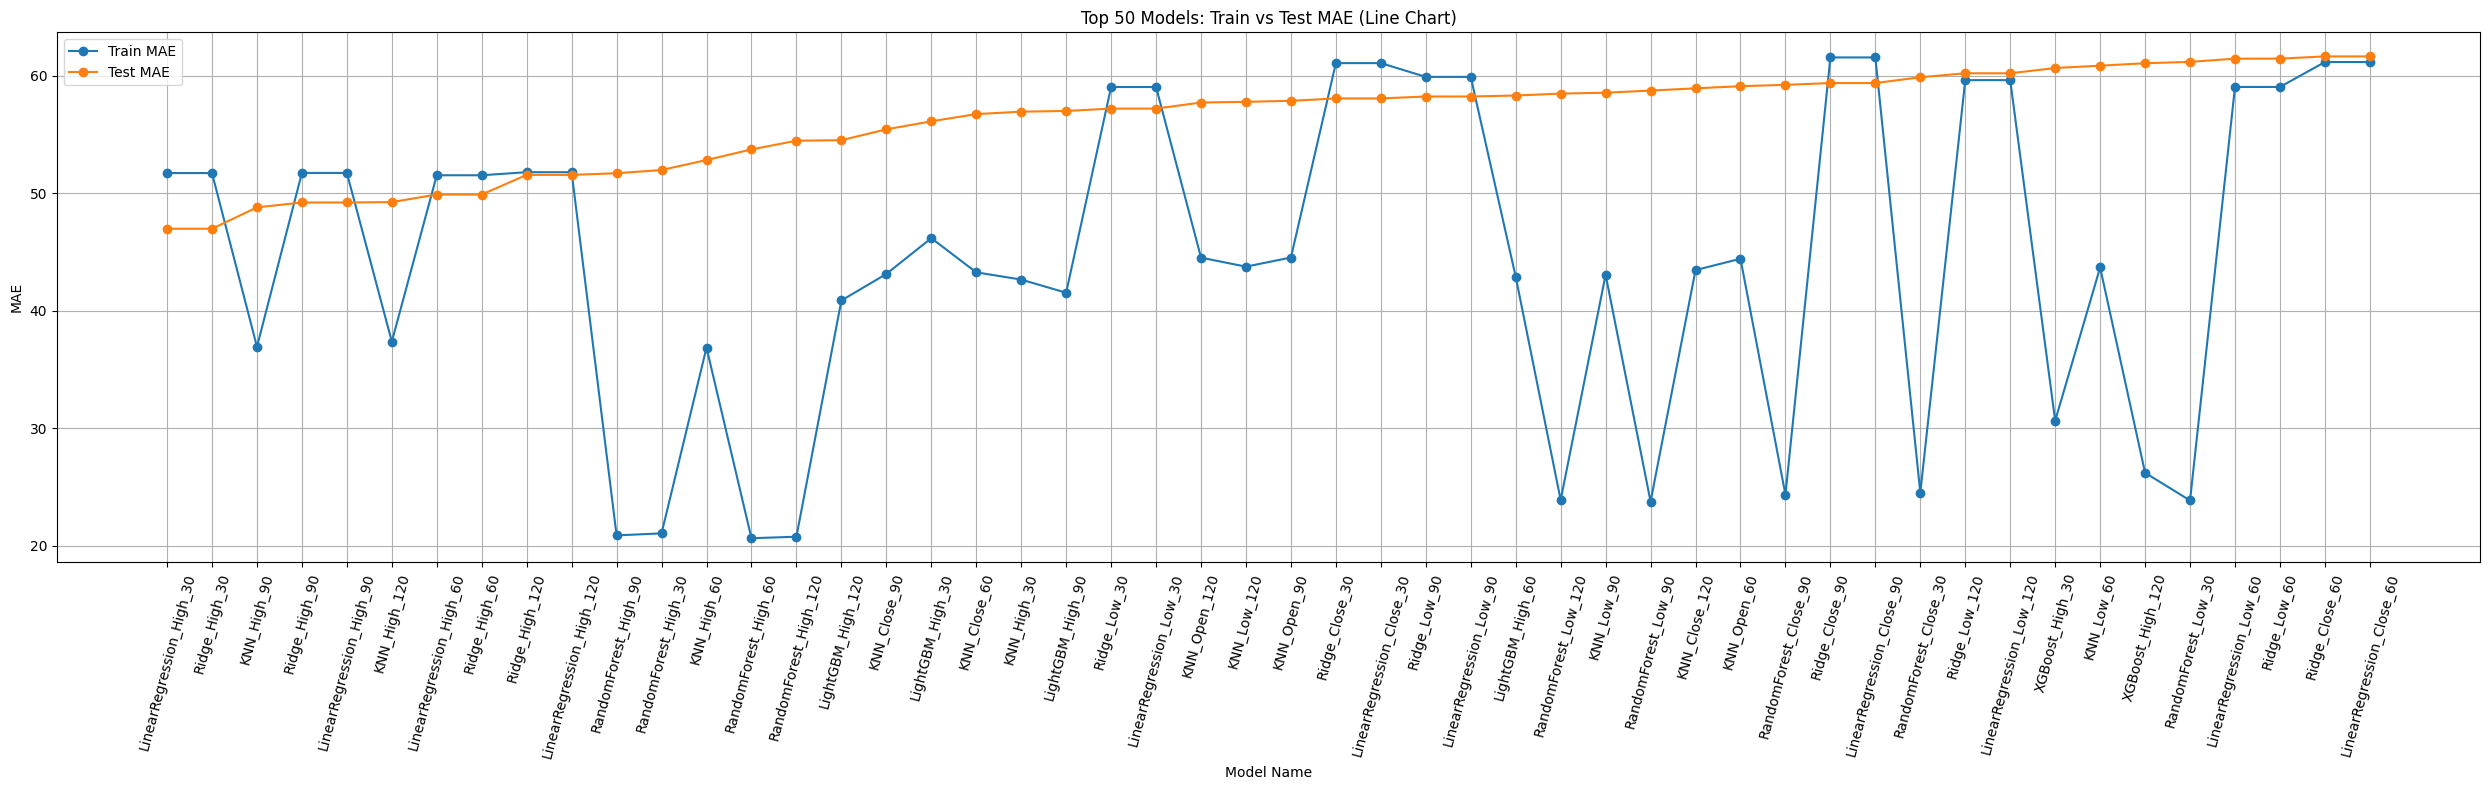

In [9]:
import matplotlib.pyplot as plt

top_50 = results_df.sort_values(by='test_mae', ascending=True).head(50)

plt.figure(figsize=(25, 8))
plt.plot(top_50['Model'], top_50['train_mae'], marker='o', label='Train MAE')

plt.plot(top_50['Model'], top_50['test_mae'], marker='o', label='Test MAE')

plt.xticks(rotation=75)
plt.xlabel('Model Name')
plt.ylabel('MAE')
plt.title('Top 50 Models: Train vs Test MAE (Line Chart)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

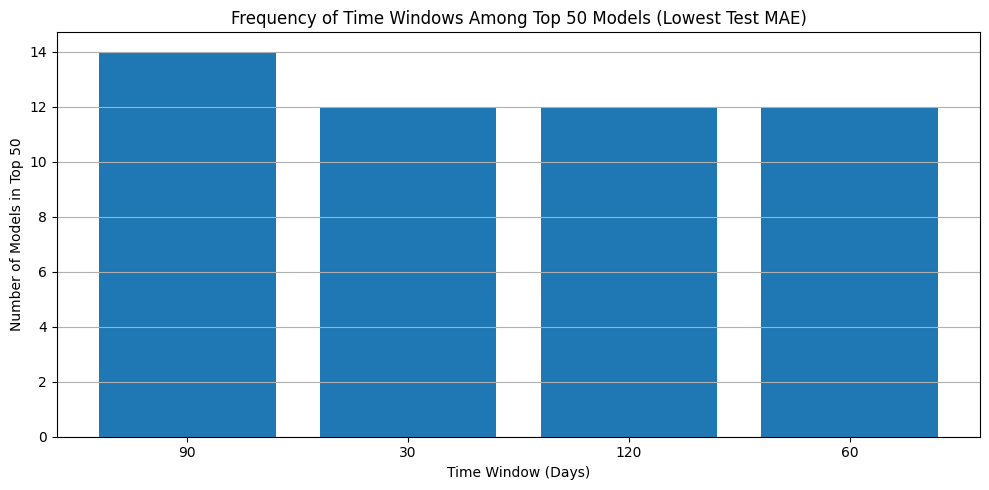

In [10]:
top_50 = results_df.sort_values(by='test_mae', ascending=True).head(50)
time_windows = pd.Series([i.split('_')[-1] for i in top_50['Model']])
time_counts = time_windows.value_counts().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
plt.bar(time_counts.index, time_counts.values)

# Labels and aesthetics
plt.xlabel('Time Window (Days)')
plt.ylabel('Number of Models in Top 50')
plt.title('Frequency of Time Windows Among Top 50 Models (Lowest Test MAE)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

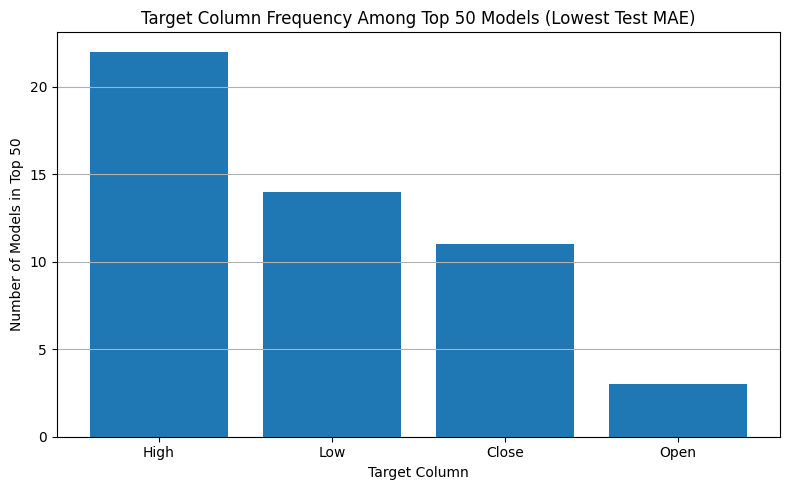

In [11]:
top_50 = results_df.sort_values(by='test_mae', ascending=True).head(50)
target_columns = pd.Series([i.split('_')[-2] for i in top_50['Model']])
target_counts = target_columns.value_counts().sort_values(ascending=False)

# Plotting
plt.figure(figsize=(8, 5))
plt.bar(target_counts.index, target_counts.values)

# Labels and aesthetics
plt.xlabel('Target Column')
plt.ylabel('Number of Models in Top 50')
plt.title('Target Column Frequency Among Top 50 Models (Lowest Test MAE)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

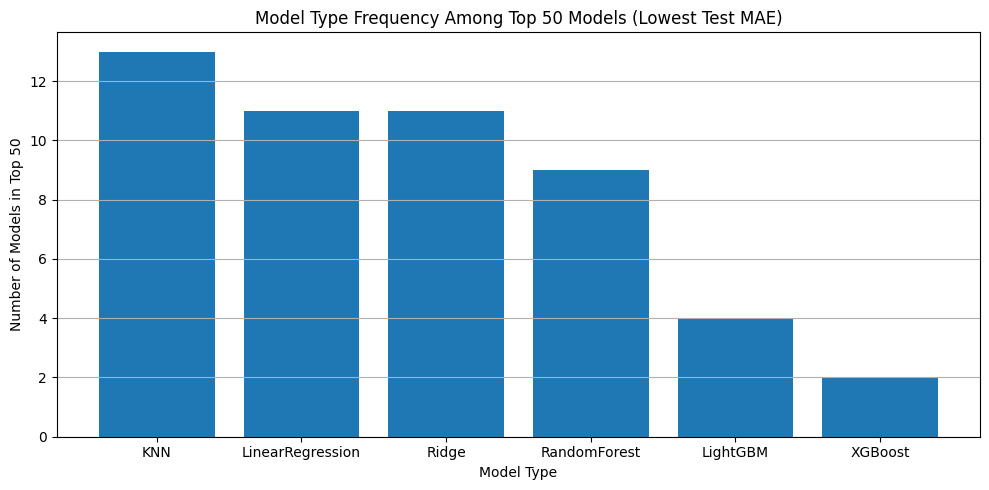

In [12]:
top_50 = results_df.sort_values(by='test_mae', ascending=True).head(50)
model_types = pd.Series([i.split('_')[0] for i in top_50['Model']])
model_counts = model_types.value_counts().sort_values(ascending=False)

# Plotting
plt.figure(figsize=(10, 5))
plt.bar(model_counts.index, model_counts.values)

# Labels and aesthetics
plt.xlabel('Model Type')
plt.ylabel('Number of Models in Top 50')
plt.title('Model Type Frequency Among Top 50 Models (Lowest Test MAE)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [17]:
import joblib

results_df.to_csv('models.csv')
joblib.dump(trained_models, 'trained_models.joblib')

loaded_models = joblib.load('trained_models.joblib')

In [15]:
import os
print(os.path.exists('trained_models.joblib'))

True


In [16]:
import joblib
loaded_models = joblib.load('trained_models.joblib')

In [18]:
loaded_models['KNN_High_90']
model = loaded_models['KNN_High_90']['model']

In [19]:
print(chunked_data['X_Open_90'][5])
print(model.predict([chunked_data['X_Open_90'][5]]))

[1615.65 1633.25 1572.3  1627.85 1622.15 1623.5  1611.65 1610.05 1634.65
 1601.25 1623.05 1612.95 1600.5  1603.65 1598.35 1546.2  1554.2  1591.25
 1598.5  1599.8  1636.6  1666.95 1692.1  1712.85 1777.75 1744.5  1704.85
 1710.05 1742.3  1719.55 1754.2  1745.2  1696.4  1734.05 1711.15 1722.85
 1661.5  1713.65 1696.45 1656.   1711.85 1717.75 1667.45 1647.85 1601.4
 1561.55 1546.8  1620.4  1563.3  1551.05 1590.3  1554.2  1570.45 1563.3
 1569.3  1556.95 1545.55 1528.7  1534.05 1428.5  1436.15 1453.3  1557.55
 1613.   1624.4  1587.95 1518.55 1443.55 1417.75 1405.7  1416.05 1383.8
 1362.5  1436.15 1419.9  1410.   1330.15 1317.95 1381.9  1423.25 1362.45
 1380.4  1359.1  1305.3  1281.3  1300.2  1310.8  1311.3  1293.45 1267.85]
[1261.65]
